# Plotting Drake Passage Transport in ACCESS-OM3

This notebook uses the initial spinup simulation of ACCESS-OM3.

In [ ]:
#The following cell must be in all notebooks!

In [ ]:
### USER EDIT start
esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
plotfolder='/new_random_path/'
### USER EDIT stop

#inspired by...
#https://stackoverflow.com/questions/37534440/passing-command-line-arguments-to-argv-in-jupyter-ipython-notebook
import sys,os,argparse
from IPython.display import HTML
CONFIG_FILE = 'config_ipynb_tmp'

if os.path.isfile(CONFIG_FILE):
    with open(CONFIG_FILE) as f:
        sys.argv = f.read().split()
        fromscript=True
else:
    sys.argv = ['run_nb.py', 'dummy', esm_file, '--plotfolder', plotfolder]
    fromscript=False

parser = argparse.ArgumentParser()
parser.add_argument("scriptname",help="script name.")
parser.add_argument("esm_file",help="intake esm datastore, will be .json file.")
parser.add_argument("--plotfolder",help="an optional path to put plots into.")
args = parser.parse_args()
if fromscript:
    print("running from a script with arguments: ")
else: 
    print("running from a notebook directly with arguments: ")
print(args.scriptname,args.esm_file,args.plotfolder)

In [1]:
import intake
from dask.distributed import Client
import matplotlib.pyplot as plt
import cmocean as cm
import cftime


In [2]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/proxy/8787/status


## Load ACCESS-OM3 data from ESM datastore

In [3]:
#datastore_path = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [4]:
umo_2d = datastore.search(variable="umo_2d").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    )
)

## Load ACCESS-OM2 data from ACCESS-NRI Catalog

In [5]:
catalog = intake.cat.access_nri

In [6]:
var = catalog['025deg_jra55_ryf9091_gadi'].search(variable='tx_trans_int_z',frequency="1mon")
var.esmcat.aggregation_control.groupby_attrs = ['frequency']  ## Not sure why I have to do this!!
tx_trans_int_z=var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


## Just to show the latitude I've picked ...

(-80.0, -40.0)

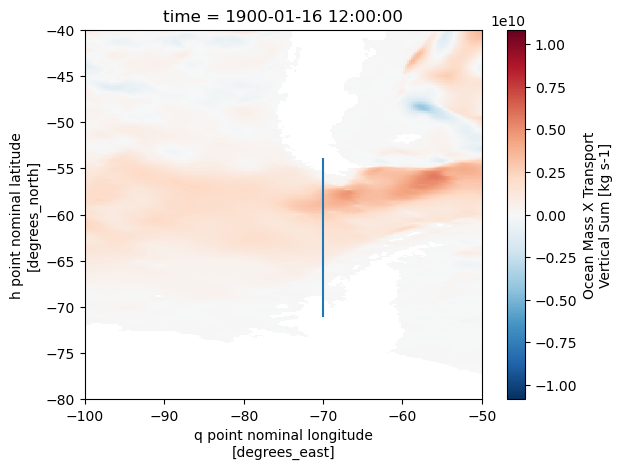

In [7]:
umo_2d["umo_2d"].isel(time=0).plot()
plt.plot([-70,-70],[-71,-54])
plt.xlim([-100,-50])
plt.ylim([-80,-40])

## Timeseries of DP Transport at -70Â°

In [8]:
DP_Trans_OM3 = umo_2d["umo_2d"].sel(xq=-70,method='nearest').sel(yh=slice(-71,-54)).sum("yh").load() / 1025 / 1e6

In [9]:
DP_Trans_OM2 = tx_trans_int_z["tx_trans_int_z"].sel(xu_ocean=-70,method='nearest').sel(yt_ocean=slice(-71,-54)).sum("yt_ocean").sel(time=slice(cftime.datetime(1900, 1, 1,calendar='noleap'), cftime.datetime(1950, 12, 31,calendar='noleap'))).load() / 1036 / 1e6

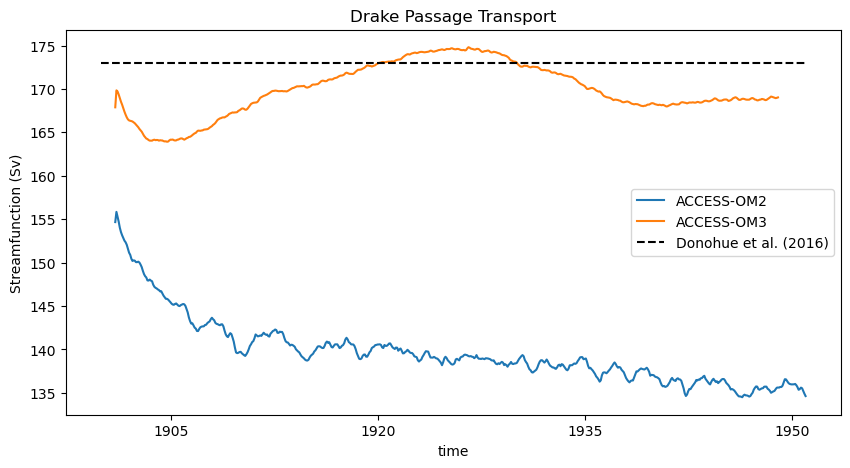

In [10]:
plt.figure(figsize=(10, 5)) 

DP_Trans_OM2.rolling(time=12).mean().plot(label='ACCESS-OM2')
DP_Trans_OM3.rolling(time=12).mean().plot(label='ACCESS-OM3')

plt.plot([cftime.datetime(1900, 1, 1), cftime.datetime(1950, 12, 31)], [173, 173],
           'k--', label="Donohue et al. (2016)")

plt.ylabel('Streamfunction (Sv)')
plt.title('Drake Passage Transport')
plt.legend()

In [11]:
client.close()